In [1]:
import random
import torch
import numpy as np
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import pickle
import sys
import os
from torch.utils.data import Dataset, DataLoader
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

from segment_anything.utils.transforms import ResizeLongestSide
import PIL
import PIL.Image as Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors


from segment_anything.utils.amg import (
    MaskData,
    area_from_rle,
    batch_iterator,
    batched_mask_to_box,
    box_xyxy_to_xywh,
    build_all_layer_point_grids,
    calculate_stability_score,
    coco_encode_rle,
    generate_crop_boxes,
    is_box_near_crop_edge,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
    uncrop_boxes_xyxy,
    uncrop_masks,
    uncrop_points,
)



In [2]:
def show_mask(mask, ax, random_color=True):
    for i in range(len(mask)):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask[i].shape[-2:]
        mask_image = mask[i].reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)
    
def show_box(box, ax):
    
    for i in range(len(box)):
        # print(batched_boxes[0][i][0])
        x0, y0 = box[i][0], box[i][1]
        w, h = box[i][2] - box[i][0], box[i][3] - box[i][1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=np.concatenate([np.random.random(3), np.array([0.6])], axis=0), facecolor=(0,0,0,0), lw=2))    

In [3]:
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

In [4]:
sam_checkpoint = "/home/harsh/Desktop/tokencut/sam/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

sam.to(device=device)

resize_transform = ResizeLongestSide(sam.image_encoder.img_size)


In [5]:
def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device) 
    return image.permute(2, 0, 1).contiguous()

In [6]:
import os
import collections

import numpy as np
import os
import argparse
import random
import pickle
from torch.utils.data import Dataset, DataLoader
import torch
import datetime
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
# from detectron2.structures import ImageList
from networks import get_model
from datasets import ImageDataset, Dataset, bbox_iou, extract_gt_VOC
from visualizations import visualize_img, visualize_eigvec, visualize_predictions, visualize_predictions_gt 
from object_discovery import ncut 
import matplotlib.pyplot as plt
import time
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
import skimage.io
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element as ET_Element
from typing import Any, Callable, Dict, List, Optional, Tuple
from scipy.linalg import eigh
import json
# from detectron2.utils.colormap import random_color
import time
import dino
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
# modfied by Xudong Wang based on third_party/TokenCut
from unsupervised_saliency_detection import utils, metric, dino
from unsupervised_saliency_detection.object_discovery import detect_box
from crf import densecrf
from datasets import ImageDataset, Dataset, bbox_iou
import random
import pickle
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

from segment_anything.utils.transforms import ResizeLongestSide
import PIL
import PIL.Image as Image
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

gpu_indices = [0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


predicted_n_file = '/home/harsh/Desktop/tokencut/original/TokenCut-master/coco_n_objects.json'

patch_size = 16
with open(predicted_n_file, 'r') as file:
            predicted_n = json.load(file)


def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device) 
    return image.permute(2, 0, 1).contiguous()

try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse
    



def show_mask(mask, ax, random_color=False):
    for i in range(len(mask)):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask[i].shape[-2:]
        mask_image = mask[i].reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


# def resize_box_coordinates(boxes, original_shape, target_shape):
#     """
#     Resize bounding box coordinates from the original image shape to the target image shape.
#     """
#     original_height, original_width = original_shape[:2]
#     target_height, target_width = target_shape[:2]

#     xmin_combined = float('inf')
#     ymin_combined = float('inf')
#     xmax_combined = -float('inf')
#     ymax_combined = -float('inf')

#     # resized_boxes = []
#     for box in boxes:
#         xmin, ymin, xmax, ymax = box
#         xmin = int(xmin * target_width / original_width)
#         xmax = int(xmax * target_width / original_width)
#         ymin = int(ymin * target_height / original_height)
#         ymax = int(ymax * target_height / original_height)

#         xmin_combined = min(xmin_combined, xmin)
#         ymin_combined = min(ymin_combined, ymin)
#         xmax_combined = max(xmax_combined, xmax)
#         ymax_combined = max(ymax_combined, ymax)

    
#     return [xmin_combined, ymin_combined, xmax_combined, ymax_combined]

def resize_box_coordinates(boxes, original_shape, target_shape):
    """
    Resize bounding box coordinates from the original image shape to the target image shape.
    """
    original_height, original_width = original_shape[:2]
    target_height, target_width = target_shape[:2]

    resized_boxes = []
    for box in boxes:
        xmin, ymin, xmax, ymax = box

        xmin_resized = int(xmin * target_width / original_width)
        xmax_resized = int(xmax * target_width / original_width)
        ymin_resized = int(ymin * target_height / original_height)
        ymax_resized = int(ymax * target_height / original_height)

        resized_box = (xmin_resized, ymin_resized, xmax_resized, ymax_resized)

        if resized_box not in resized_boxes:
            resized_boxes.append(resized_box)
        
    return resized_boxes

ToTensor = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                (0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),])

def parse_voc_xml(node: ET_Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

def get_affinity_matrix(feats, tau, eps=1e-5):
    # get affinity matrix via measuring patch-wise cosine similarity
    feats = F.normalize(feats, p=2, dim=0)
    A = (feats.transpose(0,1) @ feats).cpu().numpy()
    # convert the affinity matrix to a binary one.
    A = A > tau
    A = np.where(A.astype(float) == 0, eps, A)
    d_i = np.sum(A, axis=1)
    D = np.diag(d_i)
    return A, D

def second_smallest_eigenvector(A, D):
    # get the second smallest eigenvector from affinity matrix
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    second_smallest_vec = eigenvectors[:, 0]
    return eigenvec, second_smallest_vec

def get_salient_areas(second_smallest_vec):
    # get the area corresponding to salient objects.
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    bipartition = second_smallest_vec > avg
    return bipartition

def check_num_fg_corners(bipartition, dims):
    # check number of corners belonging to the foreground
    bipartition_ = bipartition.reshape(dims)
    top_l, top_r, bottom_l, bottom_r = bipartition_[0][0], bipartition_[0][-1], bipartition_[-1][0], bipartition_[-1][-1]
    nc = int(top_l) + int(top_r) + int(bottom_l) + int(bottom_r)
    return nc

def get_masked_affinity_matrix(painting, feats, mask, ps):
    # mask out affinity matrix based on the painting matrix 
    dim, num_patch = feats.size()[0], feats.size()[1]
    painting = painting + mask.unsqueeze(0)
    painting[painting > 0] = 1
    painting[painting <= 0] = 0
    feats = feats.clone().view(dim, ps, ps)
    feats = ((1 - painting) * feats).view(dim, num_patch)
    return feats, painting



def BatchIoU(masks1, masks2):
    n1, n2 = masks1.size()[0], masks2.size()[0]
    masks1, masks2 = (masks1>0.5).to(torch.bool), (masks2>0.5).to(torch.bool)
    masks1_ = masks1[:,None,:,:,].expand(-1, n2, -1, -1)
    masks2_ = masks2[None,:,:,:,].expand(n1, -1, -1, -1)

    intersection = torch.sum(masks1_ * (masks1_ == masks2_), dim=[-1, -2])
    union = torch.sum(masks1_ + masks2_, dim=[-1, -2])
    ious = intersection.to(torch.float) / union
    return ious

def maskcut_forward(feats, dims, scales, init_image_size, tau=0, N=3, cpu=False):
    """
    Implementation of MaskCut.
    Inputs
      feats: the pixel/patche features of an image
      dims: dimension of the map from which the features are used
      scales: from image to map scale
      init_image_size: size of the image
      tau: thresold for graph construction
      N: number of pseudo-masks per image.
    """
    bipartitions = []
    eigvecs = []
    boxes = []


    for i in range(N):
        if i == 0:
            painting = torch.from_numpy(np.zeros(dims))
            if not cpu: painting = painting.to(device)
        else:
            feats, painting = get_masked_affinity_matrix(painting, feats, current_mask, ps)

        # print(feats.shape)
        # construct the affinity matrix
        A, D = get_affinity_matrix(feats, tau)
        # get the second smallest eigenvector
        eigenvec, second_smallest_vec = second_smallest_eigenvector(A, D)
        # print(second_smallest_vec.shape)
        # get salient area
        bipartition = get_salient_areas(second_smallest_vec)

        # check if we should reverse the partition based on:
        # 1) peak of the 2nd smallest eigvec 2) object centric bias
        seed = np.argmax(np.abs(second_smallest_vec))
        nc = check_num_fg_corners(bipartition, dims)
        if nc >= 3:
            reverse = True
        else:
            reverse = bipartition[seed] != 1

        if reverse:
            # reverse bipartition, eigenvector and get new seed
            eigenvec = eigenvec * -1
            bipartition = np.logical_not(bipartition)
            seed = np.argmax(eigenvec)
        else:
            seed = np.argmax(second_smallest_vec)

        # get pxiels corresponding to the seed
        # print("bipartition",bipartition.shape)
        # print(sd)
        bipartition = bipartition.reshape(dims).astype(float)
        box, _, _, cc = detect_box(bipartition, seed, dims, scales=scales, initial_im_size=init_image_size)
        # boxes.append(box)
        
        pseudo_mask = np.zeros(dims)
        pseudo_mask[cc[0],cc[1]] = 1
        pseudo_mask = torch.from_numpy(pseudo_mask)
        if not cpu: pseudo_mask = pseudo_mask.to(device)
        ps = pseudo_mask.shape[0]

        # check if the extra mask is heavily overlapped with the previous one or is too small.
        if i >= 1:
            ratio = torch.sum(pseudo_mask) / pseudo_mask.size()[0] / pseudo_mask.size()[1]
            if metric.IoU(current_mask, pseudo_mask) > 0.5 or ratio <= 0.01:
                pseudo_mask = np.zeros(dims)
                pseudo_mask = torch.from_numpy(pseudo_mask)
                if not cpu: pseudo_mask = pseudo_mask.to(device)
        current_mask = pseudo_mask

        # mask out foreground areas in previous stages
        masked_out = 0 if len(bipartitions) == 0 else np.sum(bipartitions, axis=0)
        bipartition = F.interpolate(pseudo_mask.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
        bipartition_masked = bipartition.cpu().numpy() - masked_out
        bipartition_masked[bipartition_masked <= 0] = 0
        bipartitions.append(bipartition_masked)

        if len(boxes) == 0:
            boxes.append(box)
        
        else:
            add_box = all(bbox_iou(torch.Tensor(box), torch.Tensor(existing_box)) < 0.5 for existing_box in boxes)
            if add_box:
                boxes.append(box)
                

        # unsample the eigenvec
        eigvec = second_smallest_vec.reshape(dims)
        eigvec = torch.from_numpy(eigvec)
        if not cpu: eigvec = eigvec.to(device)
        eigvec = F.interpolate(eigvec.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
        eigvecs.append(eigvec.cpu().numpy())

    return seed, bipartitions, eigvecs, boxes

def maskcut(feats, feat_h, feat_w, patch_size, h,w, tau, N=1, fixed_size=480, cpu=False):
    # I = Image.open(img_path).convert('RGB')
    bipartitions, eigvecs = [], []


    # boxes, objects, foreground, seed , bins, eigvec, bipartition = ncut_our(feat, (feat_w, feat_h), [patch_size, patch_size], [h,w], tau, eps=1e-5, im_name='', no_binary_graph=False)

    _, bipartition, eigvec, boxes = maskcut_forward(feats, [feat_h, feat_w], [patch_size, patch_size], [h,w], tau, N=N, cpu=cpu)

    bipartitions += bipartition
    eigvecs += eigvec

    return bipartitions, eigvecs, boxes


class NpyDataset(Dataset):
    def __init__(self, image_folder_path, fixed_size, backbone, predicted_n):
        self.image_folder_path = image_folder_path
        self.file_list = os.listdir(image_folder_path)
        self.transform = transforms.ToTensor()
        self.fixed_size = fixed_size
        self.backbone = backbone
        self.predicted_n = predicted_n
        # self.annotations__path = annotations__path

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        image_name = self.file_list[idx]

        image_path = os.path.join(self.image_folder_path, image_name)

        I = Image.open(image_path).convert('RGB')

        I_new = I.resize((int(self.fixed_size), int(self.fixed_size)), PIL.Image.LANCZOS)
        I_resize, w, h, feat_w, feat_h = utils.resize_pil(I_new, patch_size)

        tensor = ToTensor(I_resize).unsqueeze(0)
        tensor = tensor.to(device)
        feats = self.backbone(tensor)[0]

        num_cuts = predicted_n.get(image_name, 1)
        if num_cuts > 5:
            num_cuts = 5
         
        return feats, image_name, tensor, w, h, feat_w, feat_h, num_cuts
    

def collate_fn_padd(batch):
        '''
        Padds batch of variable length

        note: it converts things ToTensor manually here since the ToTensor transform
        assume it takes in images rather than arbitrary tensors.
        '''
        ## get sequence lengths
        # print("batch", batch)

        
        # data_batch  = [torch.Tensor(t[0]).reshape(t[0].shape[1], t[0].shape[2]) for t in batch]
        feats  = [torch.Tensor(t[0]) for t in batch]
        file_name = [t[1] for t in batch]
               
        # feats = pad_sequence(data_batch, batch_first = True)

        image_name_batch = [t[2] for t in batch]
        image_size_batch = [t[3] for t in batch]

        image_tensors = [t[4] for t in batch]

        # images = ImageList.from_tensors(
        #     image_tensors,
        #     nn.Module.backbone.size_divisibility,
        #     padding_constraints=nn.Module.backbone.padding_constraints,
        # )


        # image_tensors_padded = pad_sequence(image_tensors, batch_first = True)


        init_image_size = [t[5] for t in batch]

        return feats, file_name, image_name_batch, image_size_batch,image_tensors, init_image_size

def load_image(dataset_name,year, im_name):
        """
        Load the image corresponding to the im_name
        """
        if "VOC" in dataset_name:
            image = skimage.io.imread(f"./datasets/VOC{year}/VOCdevkit/VOC{year}/JPEGImages/{im_name}")
        elif dataset_name == "COCO20k":
            #im_path = self.path_20k[self.sel_20k.index(im_name)]
            #im_path = self.train2014['images'][self.sel_20k.index(im_name)]['file_name']
            #image = skimage.io.imread(f"./datasets/COCO/images/train2014/{im_path}")
            image = skimage.io.imread(f"./datasets/COCO/images/train2014/{im_name}")
        else:
            raise ValueError("Unkown dataset.")
        return image


class Point_Transformer_Last(nn.Module):
    def __init__(self, channels=768, cuda_device='cuda'):
        super(Point_Transformer_Last, self).__init__()
               
        L_latent = 16 # this latent dimension can be changed according to different tasks/datasets using validation set
        self.pi_list = nn.ModuleList([nn.Sequential(nn.Linear(L_latent, channels),
                                nn.ReLU(),
                                nn.Linear(channels, 1),
                                nn.Sigmoid()) for _ in range(1)])
        self.proj_list = nn.ModuleList([nn.Linear(channels, L_latent) for _ in range(1)])
       
        # self.dt_1 = nn.Parameter(torch.FloatTensor([0.0005]))
        self.dt_1 = 0.03
        
        self.to(cuda_device)

    def TMD_map(self, x, idx):
        # input x if of size [B, d, N]
        # print("x.shape before in", x.shape)

        # idx = torch.tensor(idx).to(device=device)
        x = x.permute(0, 2, 1)

        # print("x.shape after in", x.device)
        # print(idx.device)
        x = self.proj_list[idx](x)

        # print("x after proj", x.shape)

        # L = construct from pe
        epsilon = 0.25
        i_minus_j = x.unsqueeze(2) - x.unsqueeze(1)

        # print("i_minus_j",i_minus_j.shape)
        K_epsilon = torch.exp(-1 / (4 * epsilon) * (i_minus_j ** 2).sum(dim=3))
        ### construct TMD
        q_epsilon_tilde = K_epsilon.sum(dim=2)
        D_epsilon_tilde = torch.diag_embed(self.pi_list[idx](x).squeeze(2) / q_epsilon_tilde)
        K_tilde = K_epsilon.bmm(D_epsilon_tilde)
        D_tilde = torch.diag_embed(K_tilde.sum(dim=2) +
                                   1e-5 * torch.ones(K_tilde.shape[0], K_tilde.shape[1]).to(x.device))
        L = 1 / epsilon * (torch.inverse(D_tilde).bmm(K_tilde)) - torch.eye(K_tilde.shape[1]).to(
            x.device).unsqueeze(0).repeat(x.shape[0], 1, 1)
        
        # print("L", L.shape)
        # print("L as", L)
        return L

    def forward(self, x, x_original):
        # 
        # b, 3, npoint, nsample  
        # conv2d 3 -> 128 channels 1, 1
        # b * npoint, c, nsample 
        # permute reshape

        # batch_size, _, N = x.size()
        # print("x intitial", x.shape)
        x = torch.squeeze(x, 1)

        

        # print(sd)
        # x_original = x_original.permute(0, 1, 3, 2)
        # print("x_original",x_original.shape)
        x = x.permute(0, 2, 1)

        # print("x after", x.shape)

        x_original = x_original.reshape(x_original.shape[0], 768, 1024)
        
        # x_original = torch.unsqueeze(x_original, 2)

        # print("x_original",x_original.shape)
        # print(sd)
        if True:
            # x_orig = original images input
            #to be passed
            # x = feature from transformer    # x = F.relu(self.bn1(self.conv1(x)))
            
            # x = x.permute(0, 2, 1)
            # print("x.shape", x.shape)
            L = self.TMD_map(x_original, idx=0)
            L = L.squeeze(1).squeeze(1)
            # print("new_L",L)
            # cls_token = x[0,0:1,:]
            x = (x + self.dt_1 * torch.matmul(L, x)).permute(0, 2, 1)
            # x = x.permute(0, 2, 1)
            # x = torch.unsqueeze(x, 1)
            # print("x.shape after", x.shape)

            # print(sd)
            # x[:,0:1,:]
 
        return x
    


In [7]:
# batch_info = []
# batched_boxes = []

# feat_dim = 384

# url = "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

# backbone = dino.ViTFeat(url, feat_dim, "small", "k", 16)

# backbone = nn.DataParallel(backbone, device_ids=gpu_indices)

# # msg = 'Load {} pre-trained feature...'.format(args.vit_arch)
# # print (msg)
# backbone.eval()
# backbone.to(device)

# dataset_path = '/home/harsh/Desktop/tokencut/original/TokenCut-master/datasets/COCO/coco_20k'

# dataset  = NpyDataset(dataset_path, 512, backbone, predicted_n)
# batch_size = 1  # Set your desired batch size here

# # lambda x: x
# # , collate_fn=collate_fn_padd
# data_loader_voco = DataLoader(dataset,batch_size=batch_size,shuffle=False, num_workers=0)

# tmd_initiate = Point_Transformer_Last(cuda_device = device)

# corloc = np.zeros(len(data_loader_voco)*batch_size)
# # print(len(corloc))
# start_time = time.time() 
# pbar = tqdm(data_loader_voco)
# patch_size = 16
# cnt = 0
# for im_id, inp in enumerate(pbar):
#     # for t in inp:
#     #      print("s",t[0].reshape(t[0].shape[-2], t[0].shape[-1]).shape)

#     feats, image_name, I_tensor, w, h, feat_w, feat_h, batch_N = inp

#     # print("I_array",I_array.shape)

#     # print(feats.shape)
#     # print(batch_N)
    
#     scales = [16, 16]

#     # tau = 0.2
#     # eps = 1e-05

#     # print("feats", feats.shape)
#     # print("image_tensor",image_tensor.shape)

#     # new_feats = tmd_initiate(feats, I_tensor)


#     # new_feats = feats        
#     # print("new_feats", new_feats.shape)
#     # print(sd)
#     # print(type(new_feats))
#     # print("feats", torch.tensor(feats))

#     # for idx in range(len(image_tensor)):

#     #     print("image_tensor",image_tensor[idx].shape)

    
#         # print("new_feats",new_feats.shape)
#         # print(sd)
    
#     batched_input = []
#     batched_images = []
#     boxes = []
#     with torch.no_grad():
#         for idx in range(len(feats)):

#             # boxes = []


#             # get pseudo-masks for each image using MaskCut
#             try:
#                 bipartitions, _, box = maskcut(feats[idx], feat_h[idx], feat_w[idx], 16, \
#                     h[idx], w[idx], 0.2, N=batch_N[idx], fixed_size=512)


#             except:
#                 print(f'Skipping {image_name[idx]}')
#                 continue
                
#             input_boxes = torch.tensor(box).to(device=device)
            
#             print("predicted boxes", batch_N[idx])
#             img_path = os.path.join(dataset_path, image_name[idx])

#             I = Image.open(img_path).convert('RGB')
#             I_array = np.array(I)
    
#             # print("I_tensor",I_tensor[idx].squeeze(0).shape) 

#             target_image_shape = I_array.shape

#             # print("target_image_shape",target_image_shape)
#             # print(sd)
#             resized_boxes = resize_box_coordinates(input_boxes, (512, 512), target_image_shape)
#             image_idx_boxes = torch.tensor(resized_boxes, device=device)

#             batched_boxes.append(resized_boxes)
           


#             batched_images.append(I_array)

#             file_info = {'image': prepare_image(I_array, resize_transform, device),
#                         'boxes': resize_transform.apply_boxes_torch(image_idx_boxes, I_array.shape[:2]),
#                         'original_size': I_array.shape[:2]}
            

#             batch_info.append(file_info)

#             if len(batch_info) == batch_size:
                
#                 batched_output = sam(batched_input = batch_info, multimask_output=True)

#                 for batch_id in range(len(batched_output)):
#                     # print(batched_output[batch_id]['masks'])


#                     plt.figure(figsize=(10, 10))
#                     plt.imshow(batched_images[batch_id])
#                     # for mask_id in batched_output[batch_id]['masks']:
#                     #     show_mask(mask_id.cpu().numpy(), plt.gca(), random_color=True) 
#                     for box_id in range(len(batched_boxes[batch_id])):
#                         show_box(batched_boxes[batch_id][box_id], plt.gca())

                    

#                     plt.axis('off')
#                     # plt.pause(15)
#                     plt.close()

#                     print(sd)



Loading weight from https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth


  0%|          | 0/4955 [00:00<?, ?it/s]/home/harsh/Desktop/tokencut/original/TokenCut-master/datasets.py:309: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  box2 = box2.T


predicted boxes tensor(2)
predicted boxes tensor(4)
predicted boxes tensor(3)
predicted boxes tensor(5)


  0%|          | 0/4955 [00:10<?, ?it/s]


NameError: name 'sd' is not defined

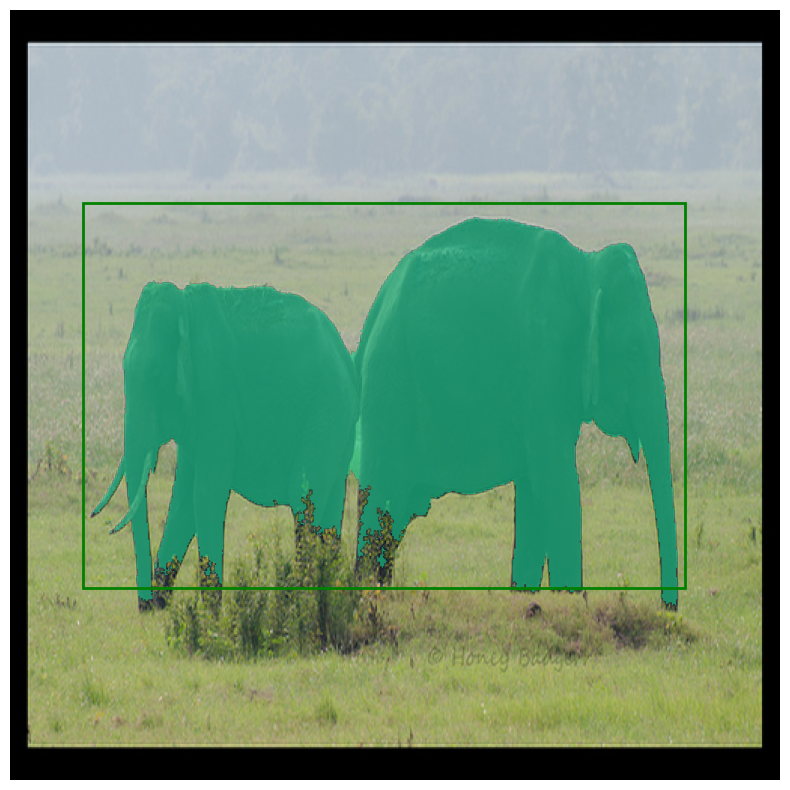

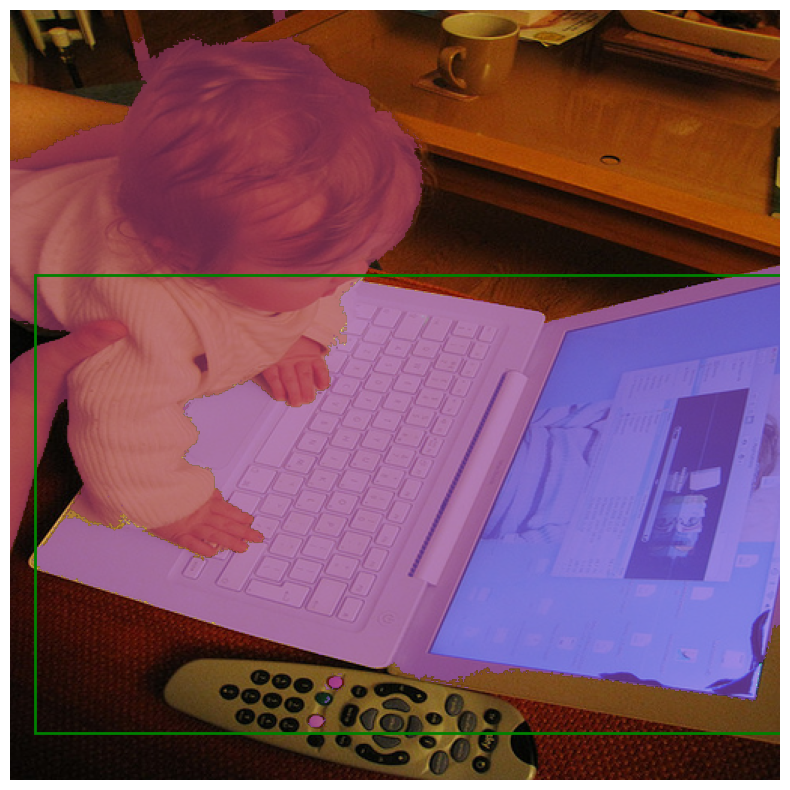

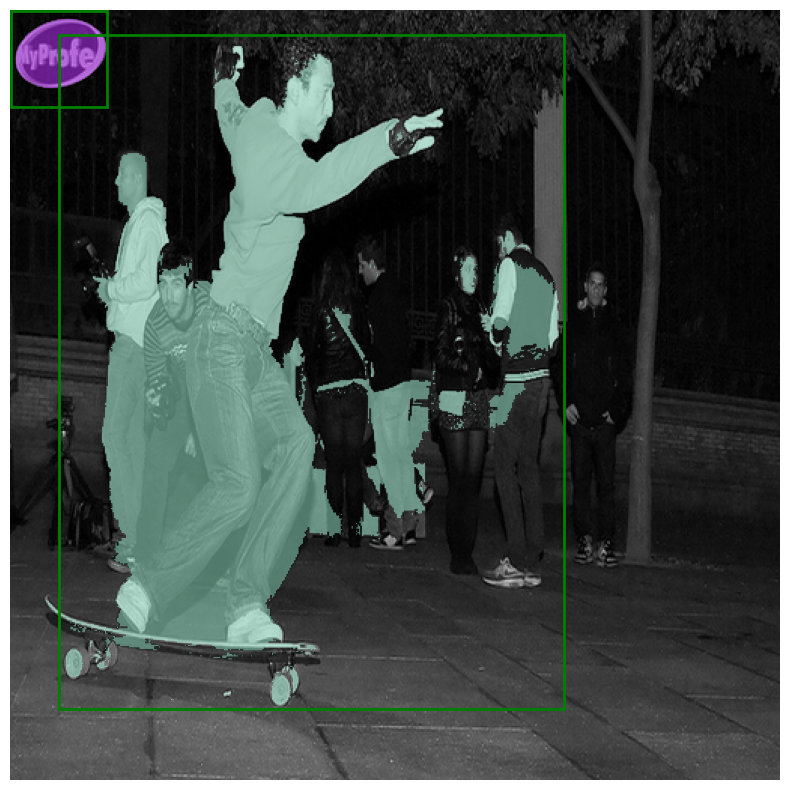

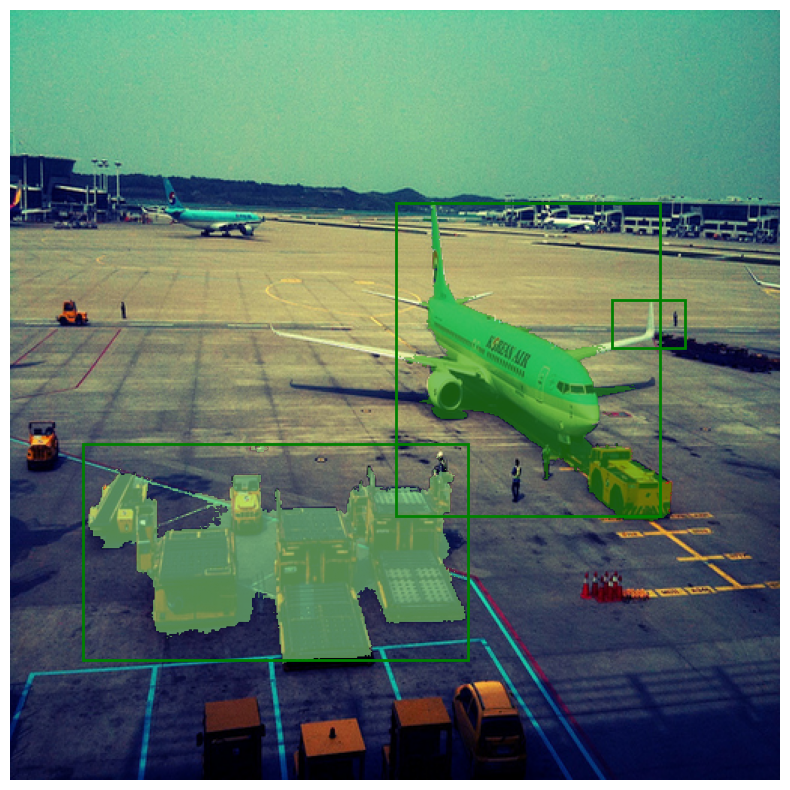

In [8]:
from scipy import ndimage

def vis_mask(input, mask, mask_color) :
    fg = mask > 0.5
    rgb = np.copy(input)
    rgb[fg] = (rgb[fg] * 0.3 + np.array(mask_color) * 0.7).astype(np.uint8)
    return Image.fromarray(rgb)

hardcoded_colors = [
        np.array([30/255, 144/255, 255/255, 0.6]),  # Dodger Blue
        np.array([255/255, 69/255, 0/255, 0.6]),     # Red-Orange
        np.array([0/255, 128/255, 0/255, 0.6]),      # Green
        np.array([138/255, 43/255, 226/255, 0.6]),   # Blue-Violet
        np.array([255/255, 215/255, 0/255, 0.6])     # Gold
    ]

def show_mask(mask, ax, random_color=True):
    # for i in range(len(mask)):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

        
batch_info = []
batched_boxes = []

feat_dim = 384

url = "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

backbone = dino.ViTFeat(url, feat_dim, "small", "k", 16)

backbone = nn.DataParallel(backbone, device_ids=gpu_indices)

# msg = 'Load {} pre-trained feature...'.format(args.vit_arch)
# print (msg)
backbone.eval()
backbone.to(device)

dataset_path = '/home/harsh/Desktop/tokencut/original/TokenCut-master/datasets/COCO/coco_20k'

dataset  = NpyDataset(dataset_path, 512, backbone, predicted_n)
batch_size = 4  # Set your desired batch size here

# lambda x: x
# , collate_fn=collate_fn_padd
data_loader_voco = DataLoader(dataset,batch_size=batch_size,shuffle=False, num_workers=0)

tmd_initiate = Point_Transformer_Last(cuda_device = device)

corloc = np.zeros(len(data_loader_voco)*batch_size)
# print(len(corloc))
start_time = time.time() 
pbar = tqdm(data_loader_voco)
patch_size = 16
cnt = 0
for im_id, inp in enumerate(pbar):
    # for t in inp:
    #      print("s",t[0].reshape(t[0].shape[-2], t[0].shape[-1]).shape)

    feats, image_name, I_tensor, w, h, feat_w, feat_h, batch_N = inp

    # print("I_array",I_array.shape)

    # print(feats.shape)
    # print(batch_N)
    
    scales = [16, 16]

    # tau = 0.2
    # eps = 1e-05

    # print("feats", feats.shape)
    # print("image_tensor",image_tensor.shape)

    new_feats = tmd_initiate(feats, I_tensor)


    # new_feats = feats        
    # print("new_feats", new_feats.shape)
    # print(sd)
    # print(type(new_feats))
    # print("feats", torch.tensor(feats))

    # for idx in range(len(image_tensor)):

    #     print("image_tensor",image_tensor[idx].shape)

    
        # print("new_feats",new_feats.shape)
        # print(sd)
    
    batched_input = []
    batched_images = []
    boxes = []
    with torch.no_grad():
        for idx in range(len(new_feats)):

            # boxes = []


            # get pseudo-masks for each image using MaskCut
            try:
                bipartitions, _, box = maskcut(new_feats[idx], feat_h[idx], feat_w[idx], 16, \
                    h[idx], w[idx], 0.2, N=batch_N[idx], fixed_size=512)


            except:
                print(f'Skipping {image_name[idx]}')
                continue
                
            input_boxes = torch.tensor(box).to(device=device)
            
            print("predicted boxes", batch_N[idx])
            img_path = os.path.join(dataset_path, image_name[idx])

            I = Image.open(img_path).convert('RGB')
            I_new = I.resize((512, 512), PIL.Image.LANCZOS)

            width, height = I_new.size
            I_array = np.array(I_new)
    
            # print("I_tensor",I_tensor[idx].squeeze(0).shape) 

            target_image_shape = I_array.shape

            # print("target_image_shape",target_image_shape)
            # print(sd)
            resized_boxes = resize_box_coordinates(input_boxes, (512, 512), target_image_shape)
            image_idx_boxes = torch.tensor(resized_boxes, device=device)

            # batched_boxes.append(resized_boxes)
           

                        
            pseudo_mask_list = []
            for idx, bipartition in enumerate(bipartitions):
                # post-process pesudo-masks with CRF
                pseudo_mask = densecrf(np.array(I_new), bipartition)
                pseudo_mask = ndimage.binary_fill_holes(pseudo_mask>=0.5)

                # filter out the mask that have a very different pseudo-mask after the CRF
         
                mask1 = torch.from_numpy(bipartition)
                mask2 = torch.from_numpy(pseudo_mask)

                # print(mask1.shape)
                # print(mask2.shape)

                if metric.IoU(mask1, mask2) < 0.5:
                    pseudo_mask = pseudo_mask * -1

                # construct binary pseudo-masks
                pseudo_mask[pseudo_mask < 0] = 0
                pseudo_mask = Image.fromarray(np.uint8(pseudo_mask*255))
                pseudo_mask = np.asarray(pseudo_mask.resize((width, height)))

                pseudo_mask = pseudo_mask.astype(np.uint8)
                upper = np.max(pseudo_mask)
                lower = np.min(pseudo_mask)
                thresh = upper / 2.0
                pseudo_mask[pseudo_mask > thresh] = upper
                pseudo_mask[pseudo_mask <= thresh] = lower
                pseudo_mask_list.append(pseudo_mask)

        
            plt.figure(figsize=(10, 10))
            plt.imshow(I_array)

            # for pseudo_mask in pseudo_mask_list:
            for mask_id in pseudo_mask_list:
                

                show_mask(mask_id.astype(bool), plt.gca(), random_color=True) 

            for box_id in range(len(resized_boxes)):
                show_box(resized_boxes[box_id], plt.gca())

            

            plt.axis('off')
            # plt.pause(15)
            

        print(sd)

            # batched_images.append(I_array)

            # file_info = {'image': prepare_image(I_array, resize_transform, device),
            #             'boxes': resize_transform.apply_boxes_torch(image_idx_boxes, I_array.shape[:2]),
            #             'original_size': I_array.shape[:2]}
            

            # batch_info.append(file_info)

            # if len(batch_info) == batch_size:
                
            #     batched_output = sam(batched_input = batch_info, multimask_output=True)

            #     for batch_id in range(len(batched_output)):
            #         # print(batched_output[batch_id]['masks'])


            #         plt.figure(figsize=(10, 10))
            #         plt.imshow(batched_images[batch_id])
            #         # for mask_id in batched_output[batch_id]['masks']:
            #         #     show_mask(mask_id.cpu().numpy(), plt.gca(), random_color=True) 
            #         for box_id in range(len(batched_boxes[batch_id])):
            #             show_box(batched_boxes[batch_id][box_id], plt.gca())

                    

            #         plt.axis('off')
            #         # plt.pause(15)
            #         plt.close()

            #         print(sd)




In [ ]:
list(batched_boxes[box_id][0])

In [ ]:
pseudo_mask_list[0].astype(bool)

In [ ]:
pseudo_mask_list[0] == pseudo_mask_list[1]